In [2]:
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
import glob
from PIL import Image
import random
import numpy as np
import torchvision
from tqdm import tqdm
import os
import cv2
import pickle
import matplotlib.pyplot as plt
from torch.nn import init
%matplotlib inline

In [3]:
def init_weights(net, init_type='normal'):
    #print('initialization method [%s]' % init_type)
    if init_type == 'kaiming':
        net.apply(weights_init_kaiming)
    else:
        raise NotImplementedError('initialization method [%s] is not implemented' % init_type)

def weights_init_kaiming(m):
    classname = m.__class__.__name__
    #print(classname)
    if classname.find('Conv') != -1:
        init.kaiming_normal_(m.weight.data, a=0, mode='fan_in')
    elif classname.find('Linear') != -1:
        init.kaiming_normal_(m.weight.data, a=0, mode='fan_in')
    elif classname.find('BatchNorm') != -1:
        init.normal_(m.weight.data, 1.0, 0.02)
        init.constant_(m.bias.data, 0.0)

### compute model params
def count_param(model):
    param_count = 0
    for param in model.parameters():
        param_count += param.view(-1).size()[0]
    return param_count

class unetConv2(nn.Module):
    def __init__(self, in_size, out_size, is_batchnorm, n=2, ks=3, stride=1, padding=1):
        super(unetConv2, self).__init__()
        self.n = n
        self.ks = ks
        self.stride = stride
        self.padding = padding
        s = stride
        p = padding
        if is_batchnorm:
            for i in range(1, n+1):
                conv = nn.Sequential(nn.Conv2d(in_size, out_size, ks, s, p),
                                     nn.BatchNorm2d(out_size),
                                     nn.ReLU(inplace=True),)
                setattr(self, 'conv%d'%i, conv)
                in_size = out_size

        else:
            for i in range(1, n+1):
                conv = nn.Sequential(nn.Conv2d(in_size, out_size, ks, s, p),
                                     nn.ReLU(inplace=True),)
                setattr(self, 'conv%d'%i, conv)
                in_size = out_size

        # initialise the blocks
        for m in self.children():
            init_weights(m, init_type='kaiming')

    def forward(self, inputs):
        x = inputs
        for i in range(1, self.n+1):
            conv = getattr(self, 'conv%d'%i)
            x = conv(x)

        return x

class unetUp(nn.Module):
    def __init__(self, in_size, out_size, is_deconv, n_concat=2):
        super(unetUp, self).__init__()
        self.conv = unetConv2(in_size+(n_concat-2)*out_size, out_size, False)
        if is_deconv:
            self.up = nn.ConvTranspose2d(in_size, out_size, kernel_size=2, stride=2, padding=0)
        else:
            self.up = nn.Sequential(
                 nn.UpsamplingBilinear2d(scale_factor=2),
                 nn.Conv2d(in_size, out_size, 1))
           
        # initialise the blocks
        for m in self.children():
            if m.__class__.__name__.find('unetConv2') != -1: continue
            init_weights(m, init_type='kaiming')

    def forward(self, high_feature, *low_feature):
        outputs0 = self.up(high_feature)
        for feature in low_feature:
            c = feature.shape[2] - outputs0.shape[2]
            if c > 0:
                outputs0 = F.pad(outputs0, (c, 0, c, 0))
#             print('Output shape : {}, feature shape : {}, c : {}'.format(outputs0.shape, feature.shape, c))
            outputs0 = torch.cat([outputs0, feature], 1)
        return self.conv(outputs0)
    
class UNet_Nested(nn.Module):

    def __init__(self, in_channels=1, n_classes=2, feature_scale=2, is_deconv=True, is_batchnorm=True, is_ds=True):
        super(UNet_Nested, self).__init__()
        self.in_channels = in_channels
        self.feature_scale = feature_scale
        self.is_deconv = is_deconv
        self.is_batchnorm = is_batchnorm
        self.is_ds = is_ds

        filters = [64, 128, 256, 512, 1024]
        filters = [int(x / self.feature_scale) for x in filters]

        # downsampling
        self.maxpool = nn.MaxPool2d(kernel_size=2)
        self.conv00 = unetConv2(self.in_channels, filters[0], self.is_batchnorm)
        self.conv10 = unetConv2(filters[0], filters[1], self.is_batchnorm)
        self.conv20 = unetConv2(filters[1], filters[2], self.is_batchnorm)
        self.conv30 = unetConv2(filters[2], filters[3], self.is_batchnorm)
        self.conv40 = unetConv2(filters[3], filters[4], self.is_batchnorm)

        # upsampling
        self.up_concat01 = unetUp(filters[1], filters[0], self.is_deconv)
        self.up_concat11 = unetUp(filters[2], filters[1], self.is_deconv)
        self.up_concat21 = unetUp(filters[3], filters[2], self.is_deconv)
        self.up_concat31 = unetUp(filters[4], filters[3], self.is_deconv)

        self.up_concat02 = unetUp(filters[1], filters[0], self.is_deconv, 3)
        self.up_concat12 = unetUp(filters[2], filters[1], self.is_deconv, 3)
        self.up_concat22 = unetUp(filters[3], filters[2], self.is_deconv, 3)

        self.up_concat03 = unetUp(filters[1], filters[0], self.is_deconv, 4)
        self.up_concat13 = unetUp(filters[2], filters[1], self.is_deconv, 4)
        
        self.up_concat04 = unetUp(filters[1], filters[0], self.is_deconv, 5)
        
        # final conv (without any concat)
        self.final_1 = nn.Conv2d(filters[0], n_classes, 1)
        self.final_2 = nn.Conv2d(filters[0], n_classes, 1)
        self.final_3 = nn.Conv2d(filters[0], n_classes, 1)
        self.final_4 = nn.Conv2d(filters[0], n_classes, 1)
        self.softmax = torch.nn.Softmax(dim = 1)
        # initialise weights
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                init_weights(m, init_type='kaiming')
            elif isinstance(m, nn.BatchNorm2d):
                init_weights(m, init_type='kaiming')

    def forward(self, inputs):
        # column : 0
        X_00 = self.conv00(inputs)       # 16*512*512
        maxpool0 = self.maxpool(X_00)    # 16*256*256
        X_10= self.conv10(maxpool0)      # 32*256*256
        maxpool1 = self.maxpool(X_10)    # 32*128*128
        X_20 = self.conv20(maxpool1)     # 64*128*128
        maxpool2 = self.maxpool(X_20)    # 64*64*64
        X_30 = self.conv30(maxpool2)     # 128*64*64
        maxpool3 = self.maxpool(X_30)    # 128*32*32
        X_40 = self.conv40(maxpool3)     # 256*32*32
        # column : 1
        X_01 = self.up_concat01(X_10,X_00)
        X_11 = self.up_concat11(X_20,X_10)
        X_21 = self.up_concat21(X_30,X_20)
        X_31 = self.up_concat31(X_40,X_30)
        # column : 2
        X_02 = self.up_concat02(X_11,X_00,X_01)
        X_12 = self.up_concat12(X_21,X_10,X_11)
        X_22 = self.up_concat22(X_31,X_20,X_21)
        # column : 3
        X_03 = self.up_concat03(X_12,X_00,X_01,X_02)
        X_13 = self.up_concat13(X_22,X_10,X_11,X_12)
        # column : 4
        X_04 = self.up_concat04(X_13,X_00,X_01,X_02,X_03)

        # final layer
        final_1 = self.final_1(X_01)
        final_2 = self.final_2(X_02)
        final_3 = self.final_3(X_03)
        final_4 = self.final_4(X_04)

        final = (final_1+final_2+final_3+final_4)/4
#         final = self.softmax(final)

        if self.is_ds:
            return final
        else:
            return final_4

# Setting - 1

In [4]:
# # Create targets

# files = glob.glob('/home/vinayak/RnD/Cervix/CI_Segmentation-s1/*')
# c = 0
# for file in files:
#     c += 1
#     print(c)
#     name = file.split('/')[-1].split('.')[0]
#     img = cv2.imread(file)
#     img = np.array(img)
#     out = np.zeros((img.shape[0], img.shape[1]))
#     for i in range(img.shape[0]):
#             for j in range(img.shape[1]):
#                 # Red
#                 if img[i][j][0] == 255 and img[i][j][1] == 0 and img[i][j][2] == 0:
#                     out[i][j] = 1

#                 # Green
#                 elif img[i][j][0] == 0 and img[i][j][1] == 128 and img[i][j][2] == 0:
#                     out[i][j] = 0

#                 # Purple
#                 elif img[i][j][0] == 128 and img[i][j][1] == 0 and img[i][j][2] == 128:
#                     out[i][j] = 1

#                 # Brown
#                 elif img[i][j][0] == 51 and img[i][j][1] == 64 and img[i][j][2] == 92:
#                     out[i][j] = 2

#                 # Pink
#                 elif img[i][j][0] == 203 and img[i][j][1] == 192 and img[i][j][2] == 255:
#                     out[i][j] = 2

#                 # Gray
#                 elif img[i][j][0] == 169 and img[i][j][1] == 169 and img[i][j][2] == 169:
#                     out[i][j] = 2
                    
#                 else:
#                     out[i][j] = 3

#     os.chdir('/home/vinayak/RnD/Cervix/s1-target/')
#     out = np.array(out)
#     np.save(name, out)
#     os.chdir('/home/vinayak/RnD/Cervix/')

In [5]:
# input_img = glob.glob('Cropped Images/*')
# inputs = []
# labels_s1 = []
# c = 0
# for i in input_img:
#     c += 1
#     print(c)
#     name = i.split('/')[-1].split('.')[0]
#     img = np.array(cv2.cvtColor(cv2.imread(i), cv2.COLOR_BGR2RGB))
#     inputs.append(img)
#     lab = np.load('s1-target/' + name + '.npy')
#     labels_s1.append(lab)

In [6]:
# labels_s1 = np.array(labels_s1)
# inputs = np.array(inputs)

In [7]:
# np.save('label-s1', labels_s1)
# np.save('input', inputs)

In [8]:
labels_s1 = np.load('label-s1.npy')
inputs = np.load('input.npy')

In [9]:
# n = inputs.shape[0]
# sample = random.sample(range(0, n), n)
# sample = np.array(sample)
# np.save('sample', sample)

In [10]:
sample = np.load('sample.npy')
train = sample[:608]
val = sample[608:800]
test = sample[800:]

In [11]:
criterion = torch.nn.CrossEntropyLoss(reduction = 'mean')
unet_s1 = UNet_Nested(in_channels = 3, n_classes = 4)
optimizer = torch.optim.SGD(unet_s1.parameters(), lr = 0.01, momentum = 0.9)
unet_s1 = nn.DataParallel(unet_s1)
unet_s1.to("cuda")

DataParallel(
  (module): UNet_Nested(
    (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv00): unetConv2(
      (conv1): Sequential(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
      )
      (conv2): Sequential(
        (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
      )
    )
    (conv10): unetConv2(
      (conv1): Sequential(
        (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
      )
      (conv2): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(

In [12]:
epochs = 100
batch_size = 16
total_batches = train.shape[0] // batch_size

history_s1 = []
dev_history_s1 = []
device = "cuda"

for k in range(1, epochs + 1):
    total_loss = 0
    dev_total_loss = 0
    c = 0
    for i in tqdm(range(1, total_batches + 1), "Epoch is running :"):
      
      optimizer.zero_grad() 
        
      # Creating input and label for both training and validation set
      inp = np.zeros((batch_size, inputs.shape[1], inputs.shape[2], inputs.shape[3]))
      label = np.zeros((batch_size, labels_s1.shape[1], labels_s1.shape[2]))
      for b in range(batch_size):
            inp[b] = inputs[train[c]]
            label[b] = labels_s1[train[c]]
            c += 1
            
      inp = torch.from_numpy(inp)
      inp = inp.permute(0, 3, 1, 2).float().to(device)
      label = torch.from_numpy(label)
        
      # Generating outputs  
      outputs = unet_s1(inp)
    
      # outputs = torch.argmax(outputs, dim = 1)
      # outputs = F.one_hot(outputs, num_classes = 4)
    
      outputs = outputs.float().to(device)
      label = label.type(torch.LongTensor).to(device)
        
      # Calculating loss
      loss = criterion(outputs, label)
    
      total_loss += float(loss.item())
        
      loss.backward()
      optimizer.step()
        
    total_loss /= total_batches
    
    history_s1.append(total_loss)
    
    # Calculate validation loss
    c1 = 0
    total_dev_loss = 0
    for v in range(1, val.shape[0] // batch_size + 1):
        dev_input = np.zeros((batch_size, inputs.shape[1], inputs.shape[2], inputs.shape[3]))
        dev_label = np.zeros((batch_size, labels_s1.shape[1], labels_s1.shape[2]))
        for b in range(batch_size):
            dev_input[b] = inputs[val[c1]]
            dev_label[b] = labels_s1[val[c1]]
            c1 += 1
            
        dev_input = torch.from_numpy(dev_input)
        dev_input = dev_input.permute(0, 3, 1, 2).float().to(device)
        dev_label = torch.from_numpy(dev_label)
        
        dev_output = unet_s1(dev_input)
        dev_output = dev_output.float().to(device)
        dev_label = dev_label.type(torch.LongTensor).to(device)
        
        dev_loss = criterion(dev_output, dev_label)
    
        total_dev_loss += float(dev_loss.item())
    
    total_dev_loss /= batch_size
    dev_history_s1.append(total_dev_loss)
    
    # Print details
    print('Epoch : ' + str(k) +  ' / ' + str(epochs) + ', Loss : ' + str(total_loss)
         + ', Validation Loss : ' + str(total_dev_loss))

Epoch is running ::   0%|          | 0/38 [00:21<?, ?it/s]


KeyboardInterrupt: 

In [116]:
# # Saving the model
# torch.save(unet_s1.module.state_dict(), 'unet++-s1')

In [15]:
# Loading the model
device = torch.device("cuda")
unet_s1 = UNet_Nested(in_channels = 3, n_classes = 4)
unet_s1.load_state_dict(torch.load('unet++-s1'))
unet_s1.to(device)

UNet_Nested(
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv00): unetConv2(
    (conv1): Sequential(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (conv2): Sequential(
      (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
  )
  (conv10): unetConv2(
    (conv1): Sequential(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (conv2): Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=Tr

In [82]:
h = []
for i in dev_history_s1:
    h.append(i * 16)
dev_history_s1 = h

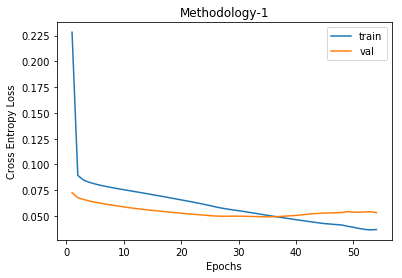

In [46]:
epoch = np.arange(1, 55)
plt.plot(epoch, history_s1)
plt.plot(epoch, dev_history_s1)
plt.xlabel('Epochs')
plt.ylabel('Cross Entropy Loss')
plt.title('Methodology-1')
plt.legend(['train', 'val'])
plt.show()

In [289]:
with open('dev_history_s2.txt', 'wb') as h:
    pickle.dump(str(dev_history_s2), h)

# Visualizing the results 

In [141]:
k = 112
a = test[k]
inp = torch.from_numpy(inputs[a])
inp = inp.permute(2, 0, 1)
inp = torch.unsqueeze(inp, 0).to(device)
outputs = unet_s1(inp.float())
outputs = torch.argmax(outputs, dim = 1).cpu()
outputs = torch.squeeze(outputs, 0)
output = F.one_hot(outputs, num_classes = 4)

In [142]:
label = labels_s1[a]
out = np.zeros((300, 300, 4))
for i in range(label.shape[0]):
  for j in range(label.shape[1]):
    if label[i][j] == 0:
      out[i][j][0] = 1
    elif label[i][j] == 1:
      out[i][j][1] = 1
    if label[i][j] == 2:
      out[i][j][2] = 1
    if label[i][j] == 3:
      out[i][j][3] = 1

Text(0.5, 1.0, 'Input Image')

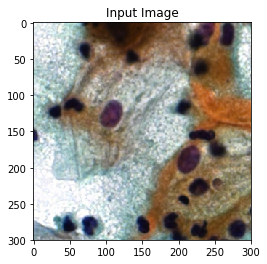

In [143]:
plt.imshow(inputs[a])
plt.title('Input Image')

Text(0.5, 1.0, 'Background (Ground Truth)')

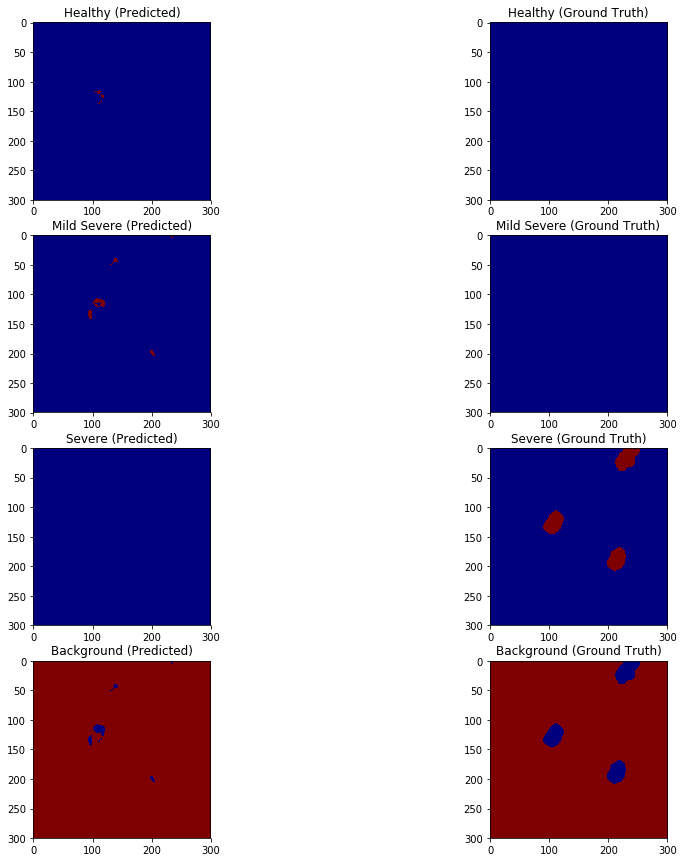

In [144]:
h, m, s, b = cv2.split(np.array(output))
h1, m1, s1, b1 = cv2.split(np.array(out))
f, ax = plt.subplots(4, 2, figsize = (15, 15))
ax[0, 0].imshow(h, cmap = 'jet')
ax[0, 0].set_title('Healthy (Predicted)')
ax[0, 1].imshow(h1, cmap = 'jet')
ax[0, 1].set_title('Healthy (Ground Truth)')

ax[1, 0].imshow(m, cmap = 'jet')
ax[1, 0].set_title('Mild Severe (Predicted)')
ax[1, 1].imshow(m1, cmap = 'jet')
ax[1, 1].set_title('Mild Severe (Ground Truth)')

ax[2, 0].imshow(s, cmap = 'jet')
ax[2, 0].set_title('Severe (Predicted)')
ax[2, 1].imshow(s1, cmap = 'jet')
ax[2, 1].set_title('Severe (Ground Truth)')

ax[3, 0].imshow(b, cmap = 'jet')
ax[3, 0].set_title('Background (Predicted)')
ax[3, 1].imshow(b1, cmap = 'jet')
ax[3, 1].set_title('Background (Ground Truth)')

# Setting - 2

In [63]:
# # Create targets

# files = glob.glob('/home/vinayak/RnD/Cervix/CI_Segmentation-s2/*')
# c = 0
# for file in files:
#     c += 1
#     print(c)
#     name = file.split('/')[-1].split('.')[0]
#     img = cv2.imread(file)
#     img = np.array(img)
#     out = np.zeros((img.shape[0], img.shape[1]))
#     for i in range(img.shape[0]):
#             for j in range(img.shape[1]):
#                 # Red
#                 if img[i][j][0] == 255 and img[i][j][1] == 0 and img[i][j][2] == 0:
#                     out[i][j] = 1

#                 # Green
#                 elif img[i][j][0] == 0 and img[i][j][1] == 128 and img[i][j][2] == 0:
#                     out[i][j] = 0

#                 # Purple
#                 elif img[i][j][0] == 128 and img[i][j][1] == 0 and img[i][j][2] == 128:
#                     out[i][j] = 1

#                 # Brown
#                 elif img[i][j][0] == 51 and img[i][j][1] == 64 and img[i][j][2] == 92:
#                     out[i][j] = 2

#                 # Pink
#                 elif img[i][j][0] == 203 and img[i][j][1] == 192 and img[i][j][2] == 255:
#                     out[i][j] = 2

#                 # Gray
#                 elif img[i][j][0] == 169 and img[i][j][1] == 169 and img[i][j][2] == 169:
#                     out[i][j] = 2
                    
#                 else:
#                     out[i][j] = 3

#     os.chdir('/home/vinayak/RnD/Cervix/s1-target/')
#     out = np.array(out)
#     np.save(name, out)
#     os.chdir('/home/vinayak/RnD/Cervix/')

In [64]:
# input_img = glob.glob('Cropped Images/*')
# inputs = []
# labels_s2 = []
# c = 0
# for i in input_img:
#     c += 1
#     print(c)
#     name = i.split('/')[-1].split('.')[0]
#     img = cv2.cvtColor(cv2.imread(i), cv2.COLOR_BGR2RGB)
#     inputs.append(img)
#     lab = np.load('s2-target/' + name + '.npy')
#     labels_s2.append(lab)

In [65]:
# labels_s2 = np.array(labels_s2)
# inputs = np.array(inputs)

In [66]:
# np.save('label-s2', labels_s2)

In [35]:
labels_s2 = np.load('label-s2.npy')

In [68]:
sample = np.load('sample.npy')
train = sample[:800]
val = sample[800:1000]
test = sample[1000:]

In [69]:
criterion = torch.nn.CrossEntropyLoss()
unet_s2 = UNet_Nested(in_channels = 3, n_classes = 4)
optimizer = torch.optim.SGD(unet_s2.parameters(), lr = 0.01, momentum = 0.9)
unet_s2 = nn.DataParallel(unet_s2)
unet_s2.to("cuda")

DataParallel(
  (module): UNet_Nested(
    (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv00): unetConv2(
      (conv1): Sequential(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
      )
      (conv2): Sequential(
        (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
      )
    )
    (conv10): unetConv2(
      (conv1): Sequential(
        (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
      )
      (conv2): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(

In [70]:
epochs = 50
batch_size = 16
total_batches = train.shape[0] // batch_size

history_s2 = []
dev_history_s2 = []
device = "cuda"

for k in range(1, epochs + 1):
    total_loss = 0
    dev_total_loss = 0
    c = 0
    for i in tqdm(range(1, total_batches + 1), "Epoch is running :"):
      
      optimizer.zero_grad()    
      # Creating input and label for both training and validation set
      inp = np.zeros((batch_size, inputs.shape[1], inputs.shape[2], inputs.shape[3]))
      label = np.zeros((batch_size, labels_s2.shape[1], labels_s2.shape[2]))
      for b in range(batch_size):
            inp[b] = inputs[train[c]]
            label[b] = labels_s2[train[c]]
            c += 1
            
      inp = torch.from_numpy(inp)
      inp = inp.permute(0, 3, 1, 2).float().to(device)
      label = torch.from_numpy(label)
        
      # Generating outputs  
      outputs = unet_s2(inp)
    
      # outputs = torch.argmax(outputs, dim = 1)
      # outputs = F.one_hot(outputs, num_classes = 4)
    
      outputs = outputs.float().to(device)
      label = label.type(torch.LongTensor).to(device)
        
      # Calculating loss
      loss = criterion(outputs, label)
    
      total_loss += float(loss.item())
        
      loss.backward()
      optimizer.step()
        
    total_loss /= total_batches
    
    history_s2.append(total_loss)
    
    # Calculate validation loss
    c1 = 0
    total_dev_loss = 0
    for v in range(1, val.shape[0] // batch_size + 1):
        dev_input = np.zeros((batch_size, inputs.shape[1], inputs.shape[2], inputs.shape[3]))
        dev_label = np.zeros((batch_size, labels_s2.shape[1], labels_s2.shape[2]))
        for b in range(batch_size):
            dev_input[b] = inputs[val[c1]]
            dev_label[b] = labels_s2[val[c1]]
            c1 += 1
            
        dev_input = torch.from_numpy(dev_input)
        dev_input = dev_input.permute(0, 3, 1, 2).float().to(device)
        dev_label = torch.from_numpy(dev_label)
        
        dev_output = unet_s2(dev_input)
        dev_output = dev_output.float().to(device)
        dev_label = dev_label.type(torch.LongTensor).to(device)
        
        dev_loss = criterion(dev_output, dev_label)
    
        total_dev_loss += float(dev_loss.item())
    
    total_dev_loss /= batch_size
    dev_history_s2.append(total_dev_loss)
    
    # Print details
    print('Epoch : ' + str(k) +  ' / ' + str(epochs) + ', Loss : ' + str(total_loss)
         + ', Validation Loss : ' + str(total_dev_loss))

Epoch is running :: 100%|██████████| 50/50 [00:09<00:00,  5.15it/s]


Epoch : 1 / 50, Loss : 0.8479087793827057, Validation Loss : 0.5664061233401299


Epoch is running :: 100%|██████████| 50/50 [00:09<00:00,  5.18it/s]


Epoch : 2 / 50, Loss : 0.7310744071006775, Validation Loss : 0.5538051165640354


Epoch is running :: 100%|██████████| 50/50 [00:09<00:00,  5.19it/s]


Epoch : 3 / 50, Loss : 0.719109058380127, Validation Loss : 0.5471366867423058


Epoch is running :: 100%|██████████| 50/50 [00:09<00:00,  5.18it/s]


Epoch : 4 / 50, Loss : 0.7105777597427368, Validation Loss : 0.5416029840707779


Epoch is running :: 100%|██████████| 50/50 [00:09<00:00,  5.02it/s]


Epoch : 5 / 50, Loss : 0.7029547250270843, Validation Loss : 0.5362948477268219


Epoch is running :: 100%|██████████| 50/50 [00:09<00:00,  5.10it/s]


Epoch : 6 / 50, Loss : 0.6955213046073914, Validation Loss : 0.5308681689202785


Epoch is running :: 100%|██████████| 50/50 [00:09<00:00,  5.14it/s]


Epoch : 7 / 50, Loss : 0.6881471407413483, Validation Loss : 0.5235311537981033


Epoch is running :: 100%|██████████| 50/50 [00:10<00:00,  4.90it/s]


Epoch : 8 / 50, Loss : 0.680506010055542, Validation Loss : 0.5139405205845833


Epoch is running :: 100%|██████████| 50/50 [00:09<00:00,  5.07it/s]


Epoch : 9 / 50, Loss : 0.6709747278690338, Validation Loss : 0.5041772425174713


Epoch is running :: 100%|██████████| 50/50 [00:09<00:00,  5.15it/s]


Epoch : 10 / 50, Loss : 0.6585694587230683, Validation Loss : 0.49553392827510834


Epoch is running :: 100%|██████████| 50/50 [00:09<00:00,  5.10it/s]


Epoch : 11 / 50, Loss : 0.6471708106994629, Validation Loss : 0.48916318640112877


Epoch is running :: 100%|██████████| 50/50 [00:09<00:00,  5.11it/s]


Epoch : 12 / 50, Loss : 0.6380179762840271, Validation Loss : 0.4818909801542759


Epoch is running :: 100%|██████████| 50/50 [00:10<00:00,  4.92it/s]


Epoch : 13 / 50, Loss : 0.6296909153461456, Validation Loss : 0.47721943259239197


Epoch is running :: 100%|██████████| 50/50 [00:09<00:00,  5.11it/s]


Epoch : 14 / 50, Loss : 0.6216865533590317, Validation Loss : 0.4724911190569401


Epoch is running :: 100%|██████████| 50/50 [00:09<00:00,  5.16it/s]


Epoch : 15 / 50, Loss : 0.6133389353752137, Validation Loss : 0.4673580005764961


Epoch is running :: 100%|██████████| 50/50 [00:09<00:00,  5.13it/s]


Epoch : 16 / 50, Loss : 0.6044842964410782, Validation Loss : 0.46174366772174835


Epoch is running :: 100%|██████████| 50/50 [00:10<00:00,  4.89it/s]


Epoch : 17 / 50, Loss : 0.5945246160030365, Validation Loss : 0.4540216736495495


Epoch is running :: 100%|██████████| 50/50 [00:09<00:00,  5.02it/s]


Epoch : 18 / 50, Loss : 0.5823222720623016, Validation Loss : 0.4448569267988205


Epoch is running :: 100%|██████████| 50/50 [00:09<00:00,  5.03it/s]


Epoch : 19 / 50, Loss : 0.5670255029201507, Validation Loss : 0.43537640012800694


Epoch is running :: 100%|██████████| 50/50 [00:09<00:00,  5.11it/s]


Epoch : 20 / 50, Loss : 0.5533855879306793, Validation Loss : 0.4309180974960327


Epoch is running :: 100%|██████████| 50/50 [00:09<00:00,  5.13it/s]


Epoch : 21 / 50, Loss : 0.5425478726625442, Validation Loss : 0.4292772449553013


Epoch is running :: 100%|██████████| 50/50 [00:09<00:00,  5.04it/s]


Epoch : 22 / 50, Loss : 0.5310230439901352, Validation Loss : 0.4271009545773268


Epoch is running :: 100%|██████████| 50/50 [00:09<00:00,  5.07it/s]


Epoch : 23 / 50, Loss : 0.5194114965200424, Validation Loss : 0.4269277397543192


Epoch is running :: 100%|██████████| 50/50 [00:09<00:00,  5.06it/s]


Epoch : 24 / 50, Loss : 0.5047038954496383, Validation Loss : 0.42887768521904945


Epoch is running :: 100%|██████████| 50/50 [00:09<00:00,  5.01it/s]


Epoch : 25 / 50, Loss : 0.4914137387275696, Validation Loss : 0.437947329133749


Epoch is running :: 100%|██████████| 50/50 [00:09<00:00,  5.01it/s]


Epoch : 26 / 50, Loss : 0.48009942889213564, Validation Loss : 0.451014943420887


Epoch is running :: 100%|██████████| 50/50 [00:10<00:00,  4.90it/s]


Epoch : 27 / 50, Loss : 0.4741460561752319, Validation Loss : 0.4464295990765095


Epoch is running :: 100%|██████████| 50/50 [00:10<00:00,  4.99it/s]


Epoch : 28 / 50, Loss : 0.4799835824966431, Validation Loss : 0.45255906134843826


Epoch is running :: 100%|██████████| 50/50 [00:09<00:00,  5.08it/s]


Epoch : 29 / 50, Loss : 0.4843676722049713, Validation Loss : 0.44516854360699654


Epoch is running :: 100%|██████████| 50/50 [00:09<00:00,  5.09it/s]


Epoch : 30 / 50, Loss : 0.48184150993824004, Validation Loss : 0.42532789520919323


Epoch is running :: 100%|██████████| 50/50 [00:10<00:00,  4.92it/s]


Epoch : 31 / 50, Loss : 0.4776626706123352, Validation Loss : 0.42257414758205414


Epoch is running :: 100%|██████████| 50/50 [00:10<00:00,  4.93it/s]


Epoch : 32 / 50, Loss : 0.43586024224758146, Validation Loss : 0.44001675210893154


Epoch is running :: 100%|██████████| 50/50 [00:10<00:00,  4.96it/s]


Epoch : 33 / 50, Loss : 0.4251843774318695, Validation Loss : 0.446524977684021


Epoch is running :: 100%|██████████| 50/50 [00:09<00:00,  5.06it/s]


Epoch : 34 / 50, Loss : 0.40539885878562926, Validation Loss : 0.4658799022436142


Epoch is running :: 100%|██████████| 50/50 [00:09<00:00,  5.06it/s]


Epoch : 35 / 50, Loss : 0.39230027198791506, Validation Loss : 0.4745917059481144


Epoch is running :: 100%|██████████| 50/50 [00:09<00:00,  5.09it/s]


Epoch : 36 / 50, Loss : 0.4045590603351593, Validation Loss : 0.4904414117336273


Epoch is running :: 100%|██████████| 50/50 [00:09<00:00,  5.08it/s]


Epoch : 37 / 50, Loss : 0.42612712204456327, Validation Loss : 0.41669376380741596


Epoch is running :: 100%|██████████| 50/50 [00:09<00:00,  5.05it/s]


Epoch : 38 / 50, Loss : 0.41178753674030305, Validation Loss : 0.46992093324661255


Epoch is running :: 100%|██████████| 50/50 [00:10<00:00,  4.93it/s]


Epoch : 39 / 50, Loss : 0.4292909944057465, Validation Loss : 0.45625924691557884


Epoch is running :: 100%|██████████| 50/50 [00:09<00:00,  5.03it/s]


Epoch : 40 / 50, Loss : 0.40161432564258576, Validation Loss : 0.4530821591615677


Epoch is running :: 100%|██████████| 50/50 [00:09<00:00,  5.12it/s]


Epoch : 41 / 50, Loss : 0.4093940478563309, Validation Loss : 0.4580603577196598


Epoch is running :: 100%|██████████| 50/50 [00:09<00:00,  5.06it/s]


Epoch : 42 / 50, Loss : 0.4257339781522751, Validation Loss : 0.42249477095901966


Epoch is running :: 100%|██████████| 50/50 [00:10<00:00,  5.00it/s]


Epoch : 43 / 50, Loss : 0.41485432773828507, Validation Loss : 0.41706938296556473


Epoch is running :: 100%|██████████| 50/50 [00:10<00:00,  4.84it/s]


Epoch : 44 / 50, Loss : 0.3857768613100052, Validation Loss : 0.4349831324070692


Epoch is running :: 100%|██████████| 50/50 [00:10<00:00,  4.97it/s]


Epoch : 45 / 50, Loss : 0.3452072414755821, Validation Loss : 0.44565303809940815


Epoch is running :: 100%|██████████| 50/50 [00:09<00:00,  5.09it/s]


Epoch : 46 / 50, Loss : 0.3208396601676941, Validation Loss : 0.4525766298174858


Epoch is running :: 100%|██████████| 50/50 [00:10<00:00,  4.94it/s]


Epoch : 47 / 50, Loss : 0.30665231853723524, Validation Loss : 0.4684249646961689


Epoch is running :: 100%|██████████| 50/50 [00:10<00:00,  4.85it/s]


Epoch : 48 / 50, Loss : 0.28874453514814374, Validation Loss : 0.46135636791586876


Epoch is running :: 100%|██████████| 50/50 [00:09<00:00,  5.07it/s]


Epoch : 49 / 50, Loss : 0.28418753772974015, Validation Loss : 0.4542740732431412


Epoch is running :: 100%|██████████| 50/50 [00:09<00:00,  5.12it/s]


Epoch : 50 / 50, Loss : 0.2798891824483871, Validation Loss : 0.4759671315550804


In [73]:
# # Saving the model
# torch.save(unet_s2.module.state_dict(), 'unet++-s2')

In [22]:
# Loading the model
device = torch.device("cuda")
unet_s2 = UNet_Nested(in_channels = 3, n_classes = 4)
unet_s2.load_state_dict(torch.load('unet++-s2'))
unet_s2.to(device)

UNet_Nested(
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv00): unetConv2(
    (conv1): Sequential(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (conv2): Sequential(
      (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
  )
  (conv10): unetConv2(
    (conv1): Sequential(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (conv2): Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=Tr

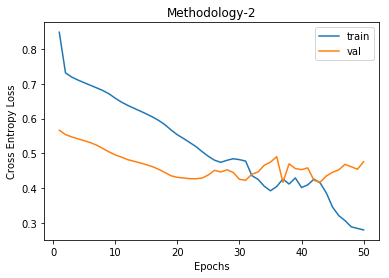

In [72]:
epoch = np.arange(1, 51)
plt.plot(epoch, history_s2)
plt.plot(epoch, dev_history_s2)
plt.xlabel('Epochs')
plt.ylabel('Cross Entropy Loss')
plt.title('Methodology-2')
plt.legend(['train', 'val'])
plt.show()

In [51]:
k = 112
a = test[k]
inp = torch.from_numpy(inputs[a])
inp = inp.permute(2, 0, 1)
inp = torch.unsqueeze(inp, 0).to(device)
outputs = unet_s2(inp.float())
outputs = torch.argmax(outputs, dim = 1).cpu()
outputs = torch.squeeze(outputs, 0)
output = F.one_hot(outputs, num_classes = 4)

In [52]:
label = labels_s2[a]
out = np.zeros((300, 300, 4))
for i in range(label.shape[0]):
  for j in range(label.shape[1]):
    if label[i][j] == 0:
      out[i][j][0] = 1
    elif label[i][j] == 1:
      out[i][j][1] = 1
    if label[i][j] == 2:
      out[i][j][2] = 1
    if label[i][j] == 3:
      out[i][j][3] = 1

Text(0.5, 1.0, 'Input Image')

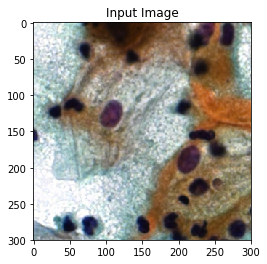

In [53]:
plt.imshow(inputs[a])
plt.title('Input Image')

Text(0.5, 1.0, 'Background (Ground Truth)')

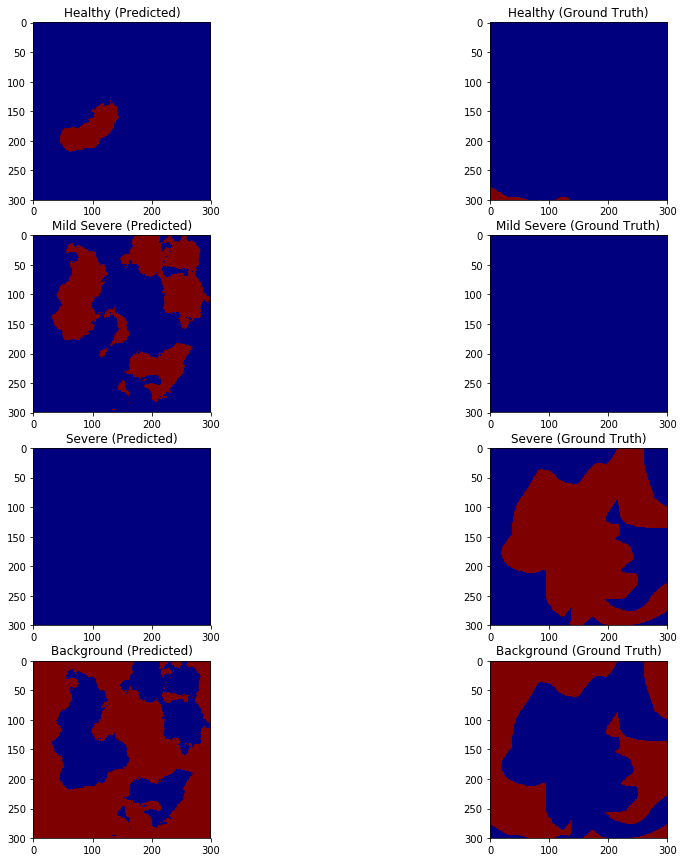

In [54]:
h, m, s, b = cv2.split(np.array(output))
h1, m1, s1, b1 = cv2.split(np.array(out))
f, ax = plt.subplots(4, 2, figsize = (15, 15))
ax[0, 0].imshow(h, cmap = 'jet')
ax[0, 0].set_title('Healthy (Predicted)')
ax[0, 1].imshow(h1, cmap = 'jet')
ax[0, 1].set_title('Healthy (Ground Truth)')

ax[1, 0].imshow(m, cmap = 'jet')
ax[1, 0].set_title('Mild Severe (Predicted)')
ax[1, 1].imshow(m1, cmap = 'jet')
ax[1, 1].set_title('Mild Severe (Ground Truth)')

ax[2, 0].imshow(s, cmap = 'jet')
ax[2, 0].set_title('Severe (Predicted)')
ax[2, 1].imshow(s1, cmap = 'jet')
ax[2, 1].set_title('Severe (Ground Truth)')

ax[3, 0].imshow(b, cmap = 'jet')
ax[3, 0].set_title('Background (Predicted)')
ax[3, 1].imshow(b1, cmap = 'jet')
ax[3, 1].set_title('Background (Ground Truth)')

# Setting - 3

In [86]:
# input_img = glob.glob('Cropped Images/*')
# inputs = []
# labels_s3 = []
# c = 0
# for i in input_img:
#     c += 1
#     print(c)
#     name = i.split('/')[-1].split('.')[0]
#     img = cv2.cvtColor(cv2.imread(i), cv2.COLOR_BGR2RGB)
#     inputs.append(img)
#     lab = np.load('s3-target/' + name + '.npy')
#     labels_s3.append(lab)

In [87]:
# labels_s3 = np.array(labels_s3)
# inputs = np.array(inputs)

In [88]:
# np.save('label-s3', labels_s3)

In [57]:
labels_s3 = np.load('label-s3.npy')

In [90]:
# n = inputs.shape[0]
# sample = random.sample(range(0, n), n)

In [91]:
criterion = torch.nn.CrossEntropyLoss()
unet_s3 = UNet_Nested(in_channels = 3, n_classes = 5)
optimizer = torch.optim.SGD(unet_s3.parameters(), lr = 0.01, momentum = 0.9)
unet_s3 = nn.DataParallel(unet_s3)
unet_s3.to("cuda")

DataParallel(
  (module): UNet_Nested(
    (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv00): unetConv2(
      (conv1): Sequential(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
      )
      (conv2): Sequential(
        (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
      )
    )
    (conv10): unetConv2(
      (conv1): Sequential(
        (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
      )
      (conv2): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(

In [92]:
epochs = 50
batch_size = 16
total_batches = train.shape[0] // batch_size

history_s3 = []
dev_history_s3 = []
device = "cuda"

for k in range(1, epochs + 1):
    total_loss = 0
    dev_total_loss = 0
    c = 0
    for i in tqdm(range(1, total_batches + 1), "Epoch is running :"):
      
      optimizer.zero_grad()    
      # Creating input and label for both training and validation set
      inp = np.zeros((batch_size, inputs.shape[1], inputs.shape[2], inputs.shape[3]))
      label = np.zeros((batch_size, labels_s3.shape[1], labels_s3.shape[2]))
      for b in range(batch_size):
            inp[b] = inputs[train[c]]
            label[b] = labels_s3[train[c]]
            c += 1
            
      inp = torch.from_numpy(inp)
      inp = inp.permute(0, 3, 1, 2).float().to(device)
      label = torch.from_numpy(label)
        
      # Generating outputs  
      outputs = unet_s3(inp)
    
      # outputs = torch.argmax(outputs, dim = 1)
      # outputs = F.one_hot(outputs, num_classes = 4)
    
      outputs = outputs.float().to(device)
      label = label.type(torch.LongTensor).to(device)
        
      # Calculating loss
      loss = criterion(outputs, label)
    
      total_loss += float(loss.item())
        
      loss.backward()
      optimizer.step()
        
    total_loss /= total_batches
    
    history_s3.append(total_loss)
    
    # Calculate validation loss
    c1 = 0
    total_dev_loss = 0
    for v in range(1, val.shape[0] // batch_size + 1):
        dev_input = np.zeros((batch_size, inputs.shape[1], inputs.shape[2], inputs.shape[3]))
        dev_label = np.zeros((batch_size, labels_s3.shape[1], labels_s3.shape[2]))
        for b in range(batch_size):
            dev_input[b] = inputs[val[c1]]
            dev_label[b] = labels_s3[val[c1]]
            c1 += 1
            
        dev_input = torch.from_numpy(dev_input)
        dev_input = dev_input.permute(0, 3, 1, 2).float().to(device)
        dev_label = torch.from_numpy(dev_label)
        
        dev_output = unet_s3(dev_input)
        dev_output = dev_output.float().to(device)
        dev_label = dev_label.type(torch.LongTensor).to(device)
        
        dev_loss = criterion(dev_output, dev_label)
    
        total_dev_loss += float(dev_loss.item())
    
    total_dev_loss /= batch_size
    dev_history_s3.append(total_dev_loss / batch_size)
    
    # Print details
    print('Epoch : ' + str(k) +  ' / ' + str(epochs) + ', Loss : ' + str(total_loss)
         + ', Validation Loss : ' + str(total_dev_loss))

Epoch is running :: 100%|██████████| 50/50 [00:09<00:00,  5.05it/s]


Epoch : 1 / 50, Loss : 0.6678437393903732, Validation Loss : 0.40145227685570717


Epoch is running :: 100%|██████████| 50/50 [00:10<00:00,  4.98it/s]


Epoch : 2 / 50, Loss : 0.5221073693037033, Validation Loss : 0.38542177341878414


Epoch is running :: 100%|██████████| 50/50 [00:10<00:00,  4.95it/s]


Epoch : 3 / 50, Loss : 0.5021878880262375, Validation Loss : 0.37149435095489025


Epoch is running :: 100%|██████████| 50/50 [00:10<00:00,  4.98it/s]


Epoch : 4 / 50, Loss : 0.4878857433795929, Validation Loss : 0.35756365582346916


Epoch is running :: 100%|██████████| 50/50 [00:10<00:00,  4.92it/s]


Epoch : 5 / 50, Loss : 0.4753366369009018, Validation Loss : 0.34802443347871304


Epoch is running :: 100%|██████████| 50/50 [00:10<00:00,  4.91it/s]


Epoch : 6 / 50, Loss : 0.4648503464460373, Validation Loss : 0.34163046814501286


Epoch is running :: 100%|██████████| 50/50 [00:10<00:00,  4.82it/s]


Epoch : 7 / 50, Loss : 0.4559210520982742, Validation Loss : 0.33662770316004753


Epoch is running :: 100%|██████████| 50/50 [00:10<00:00,  4.94it/s]


Epoch : 8 / 50, Loss : 0.4481772345304489, Validation Loss : 0.33255305886268616


Epoch is running :: 100%|██████████| 50/50 [00:10<00:00,  4.81it/s]


Epoch : 9 / 50, Loss : 0.44111441731452944, Validation Loss : 0.32936133071780205


Epoch is running :: 100%|██████████| 50/50 [00:10<00:00,  4.95it/s]


Epoch : 10 / 50, Loss : 0.4343007802963257, Validation Loss : 0.3260673824697733


Epoch is running :: 100%|██████████| 50/50 [00:10<00:00,  4.93it/s]


Epoch : 11 / 50, Loss : 0.4275022780895233, Validation Loss : 0.3221542127430439


Epoch is running :: 100%|██████████| 50/50 [00:10<00:00,  4.96it/s]


Epoch : 12 / 50, Loss : 0.42113875567913056, Validation Loss : 0.31847376376390457


Epoch is running :: 100%|██████████| 50/50 [00:10<00:00,  4.72it/s]


Epoch : 13 / 50, Loss : 0.41526605784893034, Validation Loss : 0.3159641921520233


Epoch is running :: 100%|██████████| 50/50 [00:10<00:00,  4.78it/s]


Epoch : 14 / 50, Loss : 0.4090213531255722, Validation Loss : 0.31387838535010815


Epoch is running :: 100%|██████████| 50/50 [00:10<00:00,  4.79it/s]


Epoch : 15 / 50, Loss : 0.4019658315181732, Validation Loss : 0.3126119691878557


Epoch is running :: 100%|██████████| 50/50 [00:10<00:00,  4.78it/s]


Epoch : 16 / 50, Loss : 0.3941390186548233, Validation Loss : 0.311421200633049


Epoch is running :: 100%|██████████| 50/50 [00:10<00:00,  4.79it/s]


Epoch : 17 / 50, Loss : 0.3865710932016373, Validation Loss : 0.3080264627933502


Epoch is running :: 100%|██████████| 50/50 [00:10<00:00,  4.83it/s]


Epoch : 18 / 50, Loss : 0.38122061848640443, Validation Loss : 0.3060974348336458


Epoch is running :: 100%|██████████| 50/50 [00:10<00:00,  4.76it/s]


Epoch : 19 / 50, Loss : 0.3762122768163681, Validation Loss : 0.30459818057715893


Epoch is running :: 100%|██████████| 50/50 [00:10<00:00,  4.68it/s]


Epoch : 20 / 50, Loss : 0.37133006393909457, Validation Loss : 0.30404950864613056


Epoch is running :: 100%|██████████| 50/50 [00:10<00:00,  4.77it/s]


Epoch : 21 / 50, Loss : 0.36655853033065794, Validation Loss : 0.3035485092550516


Epoch is running :: 100%|██████████| 50/50 [00:10<00:00,  4.78it/s]


Epoch : 22 / 50, Loss : 0.3617294651269913, Validation Loss : 0.3045834954828024


Epoch is running :: 100%|██████████| 50/50 [00:10<00:00,  4.97it/s]


Epoch : 23 / 50, Loss : 0.3579630869626999, Validation Loss : 0.3038373086601496


Epoch is running :: 100%|██████████| 50/50 [00:10<00:00,  4.87it/s]


Epoch : 24 / 50, Loss : 0.35578901052474976, Validation Loss : 0.3012830726802349


Epoch is running :: 100%|██████████| 50/50 [00:09<00:00,  5.03it/s]


Epoch : 25 / 50, Loss : 0.35649328351020815, Validation Loss : 0.3053068984299898


Epoch is running :: 100%|██████████| 50/50 [00:10<00:00,  4.92it/s]


Epoch : 26 / 50, Loss : 0.35720969617366793, Validation Loss : 0.30008802004158497


Epoch is running :: 100%|██████████| 50/50 [00:10<00:00,  4.95it/s]


Epoch : 27 / 50, Loss : 0.34515947818756104, Validation Loss : 0.30258394218981266


Epoch is running :: 100%|██████████| 50/50 [00:10<00:00,  4.91it/s]


Epoch : 28 / 50, Loss : 0.3410197710990906, Validation Loss : 0.3021394647657871


Epoch is running :: 100%|██████████| 50/50 [00:10<00:00,  4.87it/s]


Epoch : 29 / 50, Loss : 0.3392766857147217, Validation Loss : 0.3030514717102051


Epoch is running :: 100%|██████████| 50/50 [00:09<00:00,  5.03it/s]


Epoch : 30 / 50, Loss : 0.33603826045989993, Validation Loss : 0.30555554665625095


Epoch is running :: 100%|██████████| 50/50 [00:09<00:00,  5.02it/s]


Epoch : 31 / 50, Loss : 0.3301399505138397, Validation Loss : 0.3054978474974632


Epoch is running :: 100%|██████████| 50/50 [00:09<00:00,  5.07it/s]


Epoch : 32 / 50, Loss : 0.32428221225738524, Validation Loss : 0.30808682180941105


Epoch is running :: 100%|██████████| 50/50 [00:10<00:00,  4.95it/s]


Epoch : 33 / 50, Loss : 0.3202262672781944, Validation Loss : 0.311549274250865


Epoch is running :: 100%|██████████| 50/50 [00:10<00:00,  4.92it/s]


Epoch : 34 / 50, Loss : 0.31652141600847244, Validation Loss : 0.31426315009593964


Epoch is running :: 100%|██████████| 50/50 [00:09<00:00,  5.03it/s]


Epoch : 35 / 50, Loss : 0.31141099959611895, Validation Loss : 0.31273958645761013


Epoch is running :: 100%|██████████| 50/50 [00:10<00:00,  4.86it/s]


Epoch : 36 / 50, Loss : 0.30696625232696534, Validation Loss : 0.31164965964853764


Epoch is running :: 100%|██████████| 50/50 [00:10<00:00,  4.90it/s]


Epoch : 37 / 50, Loss : 0.3055918684601784, Validation Loss : 0.3084461372345686


Epoch is running :: 100%|██████████| 50/50 [00:09<00:00,  5.02it/s]


Epoch : 38 / 50, Loss : 0.3057002592086792, Validation Loss : 0.3117855601012707


Epoch is running :: 100%|██████████| 50/50 [00:09<00:00,  5.02it/s]


Epoch : 39 / 50, Loss : 0.3119564229249954, Validation Loss : 0.3212378993630409


Epoch is running :: 100%|██████████| 50/50 [00:10<00:00,  4.91it/s]


Epoch : 40 / 50, Loss : 0.30112494856119154, Validation Loss : 0.3285353500396013


Epoch is running :: 100%|██████████| 50/50 [00:10<00:00,  4.92it/s]


Epoch : 41 / 50, Loss : 0.29423530846834184, Validation Loss : 0.3302212916314602


Epoch is running :: 100%|██████████| 50/50 [00:10<00:00,  4.79it/s]


Epoch : 42 / 50, Loss : 0.2820128062367439, Validation Loss : 0.3363535199314356


Epoch is running :: 100%|██████████| 50/50 [00:10<00:00,  4.83it/s]


Epoch : 43 / 50, Loss : 0.27406827569007874, Validation Loss : 0.34494598768651485


Epoch is running :: 100%|██████████| 50/50 [00:10<00:00,  4.78it/s]


Epoch : 44 / 50, Loss : 0.27066321194171905, Validation Loss : 0.33928743936121464


Epoch is running :: 100%|██████████| 50/50 [00:10<00:00,  4.93it/s]


Epoch : 45 / 50, Loss : 0.2716346848011017, Validation Loss : 0.3249970357865095


Epoch is running :: 100%|██████████| 50/50 [00:10<00:00,  4.90it/s]


Epoch : 46 / 50, Loss : 0.2759735253453255, Validation Loss : 0.3403680343180895


Epoch is running :: 100%|██████████| 50/50 [00:10<00:00,  4.85it/s]


Epoch : 47 / 50, Loss : 0.27443340957164764, Validation Loss : 0.388906741514802


Epoch is running :: 100%|██████████| 50/50 [00:10<00:00,  4.75it/s]


Epoch : 48 / 50, Loss : 0.27465753108263014, Validation Loss : 0.3441006522625685


Epoch is running :: 100%|██████████| 50/50 [00:10<00:00,  4.80it/s]


Epoch : 49 / 50, Loss : 0.25551225334405897, Validation Loss : 0.34932195022702217


Epoch is running :: 100%|██████████| 50/50 [00:09<00:00,  5.02it/s]


Epoch : 50 / 50, Loss : 0.24510071873664857, Validation Loss : 0.3519982695579529


In [93]:
# # Saving the model
# torch.save(unet_s3.module.state_dict(), 'unet++-s3')

In [29]:
# Loading the model
device = torch.device("cuda")
unet_s3 = UNet_Nested(in_channels = 3, n_classes = 5)
unet_s3.load_state_dict(torch.load('unet++-s3'))
unet_s3.to(device)

UNet_Nested(
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv00): unetConv2(
    (conv1): Sequential(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (conv2): Sequential(
      (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
  )
  (conv10): unetConv2(
    (conv1): Sequential(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (conv2): Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=Tr

In [97]:
h = []
for i in dev_history_s3:
    h.append(i * 16)
dev_history_s3 = h

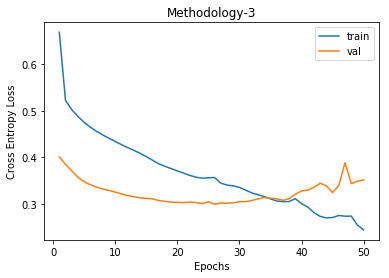

In [98]:
epoch = np.arange(1, 51)
plt.plot(epoch, history_s3)
plt.plot(epoch, dev_history_s3)
plt.xlabel('Epochs')
plt.ylabel('Cross Entropy Loss')
plt.title('Methodology-3')
plt.legend(['train', 'val'])
plt.show()

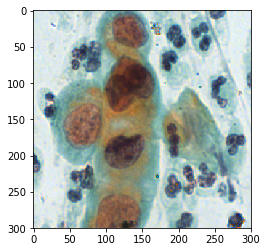

In [30]:
name = 'Image385_1'
a = np.array(cv2.cvtColor(cv2.imread('Cropped Images/'+ name +'.png'), cv2.COLOR_BGR2RGB))
label = np.load('s3-target/'+ name +'.npy')

inp = torch.from_numpy(a)
inp = inp.permute(2, 0, 1)
inp = torch.unsqueeze(inp, 0).to(device)
outputs = unet_s3(inp.float())
outputs = torch.argmax(outputs, dim = 1).cpu()
outputs = torch.squeeze(outputs, 0)
output = F.one_hot(outputs, num_classes = 5)

out = np.zeros((300, 300, 5))
for i in range(label.shape[0]):
  for j in range(label.shape[1]):
    if label[i][j] == 0:
      out[i][j][0] = 1
    elif label[i][j] == 1:
      out[i][j][1] = 1
    elif label[i][j] == 2:
      out[i][j][2] = 1
    elif label[i][j] == 3:
      out[i][j][3] = 1
    elif label[i][j] == 4:
      out[i][j][4] = 1
plt.imshow(a)

Text(0.5, 1.0, 'Background (Ground Truth)')

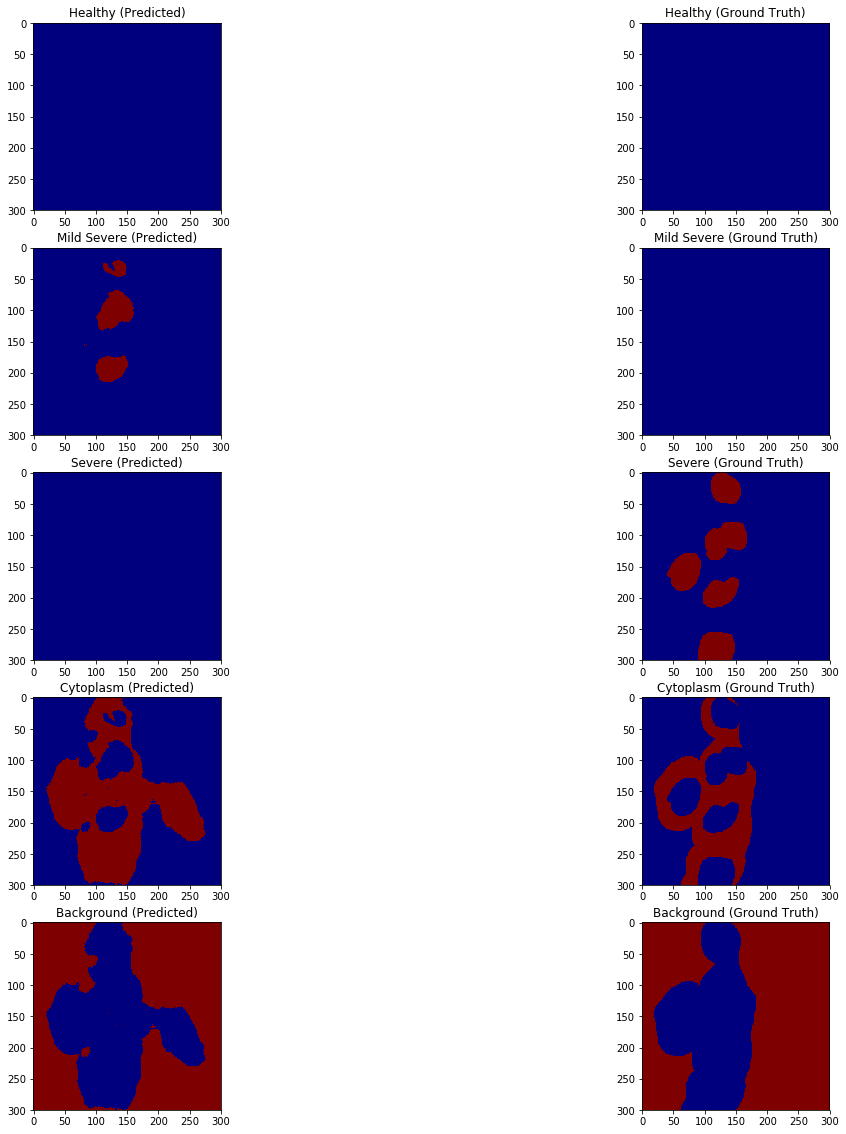

In [31]:
h, m, s, c, b = cv2.split(np.array(output))
h1, m1, s1, c1, b1 = cv2.split(np.array(out))
f, ax = plt.subplots(5, 2, figsize = (20, 20))
ax[0, 0].imshow(h, cmap = 'jet')
ax[0, 0].set_title('Healthy (Predicted)')
ax[0, 1].imshow(h1, cmap = 'jet')
ax[0, 1].set_title('Healthy (Ground Truth)')

ax[1, 0].imshow(m, cmap = 'jet')
ax[1, 0].set_title('Mild Severe (Predicted)')
ax[1, 1].imshow(m1, cmap = 'jet')
ax[1, 1].set_title('Mild Severe (Ground Truth)')

ax[2, 0].imshow(s, cmap = 'jet')
ax[2, 0].set_title('Severe (Predicted)')
ax[2, 1].imshow(s1, cmap = 'jet')
ax[2, 1].set_title('Severe (Ground Truth)')

ax[3, 0].imshow(c, cmap = 'jet')
ax[3, 0].set_title('Cytoplasm (Predicted)')
ax[3, 1].imshow(c1, cmap = 'jet')
ax[3, 1].set_title('Cytoplasm (Ground Truth)')

ax[4, 0].imshow(b, cmap = 'jet')
ax[4, 0].set_title('Background (Predicted)')
ax[4, 1].imshow(b1, cmap = 'jet')
ax[4, 1].set_title('Background (Ground Truth)')

In [108]:
inp.shape

torch.Size([1, 3, 300, 300])

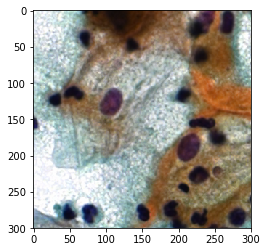

In [66]:
k = 112
a = test[k]
inp = torch.from_numpy(inputs[a])
inp = inp.permute(2, 0, 1)
inp = torch.unsqueeze(inp, 0).to(device)
outputs = unet_s3(inp.float())
outputs = torch.argmax(outputs, dim = 1).cpu()
outputs = torch.squeeze(outputs, 0)
output = F.one_hot(outputs, num_classes = 5)
label = labels_s3[a]
out = np.zeros((300, 300, 5))
for i in range(label.shape[0]):
  for j in range(label.shape[1]):
    if label[i][j] == 0:
      out[i][j][0] = 1
    elif label[i][j] == 1:
      out[i][j][1] = 1
    elif label[i][j] == 2:
      out[i][j][2] = 1
    elif label[i][j] == 3:
      out[i][j][3] = 1
    elif label[i][j] == 4:
      out[i][j][4] = 1
    
plt.imshow(inputs[a])

Text(0.5, 1.0, 'Background (Ground Truth)')

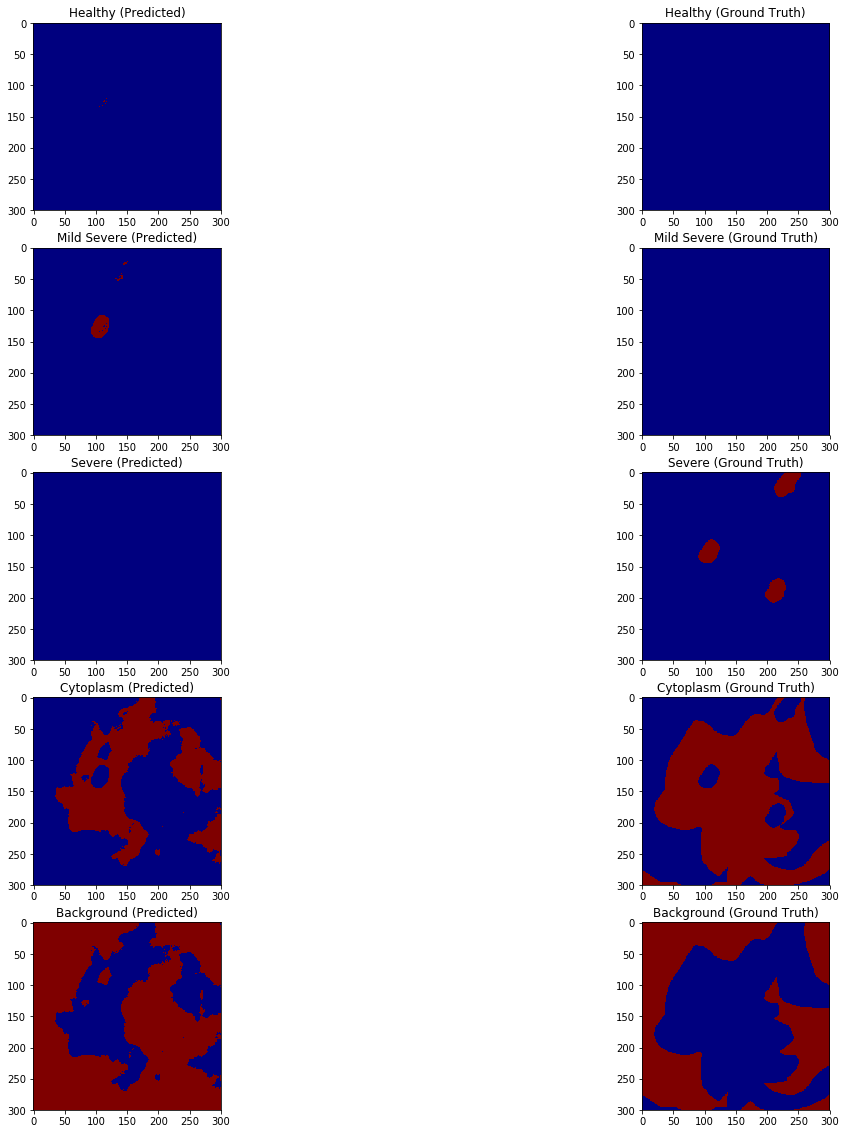

In [67]:
h, m, s, c, b = cv2.split(np.array(output))
h1, m1, s1, c1, b1 = cv2.split(np.array(out))
f, ax = plt.subplots(5, 2, figsize = (20, 20))
ax[0, 0].imshow(h, cmap = 'jet')
ax[0, 0].set_title('Healthy (Predicted)')
ax[0, 1].imshow(h1, cmap = 'jet')
ax[0, 1].set_title('Healthy (Ground Truth)')

ax[1, 0].imshow(m, cmap = 'jet')
ax[1, 0].set_title('Mild Severe (Predicted)')
ax[1, 1].imshow(m1, cmap = 'jet')
ax[1, 1].set_title('Mild Severe (Ground Truth)')

ax[2, 0].imshow(s, cmap = 'jet')
ax[2, 0].set_title('Severe (Predicted)')
ax[2, 1].imshow(s1, cmap = 'jet')
ax[2, 1].set_title('Severe (Ground Truth)')

ax[3, 0].imshow(c, cmap = 'jet')
ax[3, 0].set_title('Cytoplasm (Predicted)')
ax[3, 1].imshow(c1, cmap = 'jet')
ax[3, 1].set_title('Cytoplasm (Ground Truth)')

ax[4, 0].imshow(b, cmap = 'jet')
ax[4, 0].set_title('Background (Predicted)')
ax[4, 1].imshow(b1, cmap = 'jet')
ax[4, 1].set_title('Background (Ground Truth)')